### Series de tiempo

El objetivo de este desafío es construir un modelo de forecast que permita estimar las ventas de 3 semanas a nivel diario utilizando la historia de ventas de la categoría. Es decir, predecir las ventas de los siguientes 21 días. Las métricas y la medición de la performance del forecast son un punto clave de este desafío.

In [51]:
# Libraries
import math
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import missingno as msno
import scipy.stats as stats
from matplotlib import pyplot as plt 
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import  HistGradientBoostingRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
# Config pandas
pd.set_option('display.max_rows', None)

In [52]:
# Parameters
NAME_FILE = "series.csv"
FILES_PATH = 'Files/'

In [53]:
# Open csv file and view it of test
df = pd.read_csv(FILES_PATH+NAME_FILE)
# Names of colums to lower for convenience
df.columns = df.columns.str.lower()
# Change order of columns
df = df[['date', 'category', 'units_sold']]
print("Number of rows: "+str(df.shape[0]))
df.head()

Number of rows: 2686


,date,category,units_sold
0,2021-08-17,CATEG-1,59
1,2020-09-19,CATEG-1,40
2,2021-10-26,CATEG-2,23
3,2021-04-27,CATEG-1,60
4,2021-05-05,CATEG-2,61


In [54]:
# Prepare dataset

# Change to datetime the column date
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
# Pivot
df = pd.pivot_table(
    data = df,
    values = 'units_sold',
    index = 'date',
    columns = 'category'
)
# Columns name
df.columns.name = None
df.columns = [f"category_{category[-1]}" for category in df.columns]
df = df.asfreq("1D")
df = df.sort_index()
df.head()


,category_1,category_2,category_3
date,,,
2018-09-24,NaN,NaN,0.0
2018-09-25,NaN,NaN,0.0
2018-09-26,NaN,NaN,NaN
2018-09-27,NaN,NaN,0.0
2018-09-28,NaN,NaN,2.0


(1146, 4)


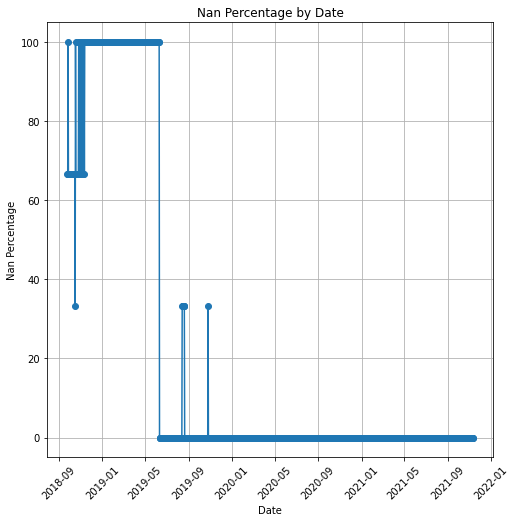

In [55]:
# Sanity check, nan values per date
df_nan = df.reset_index()
df_nan.head()
print(df_nan.shape)
# Plot nan percentage by date
nan_percentage = df_nan.isnull().sum(axis = 1) / (df_nan.shape[1]-1) * 100
# Plot the nan percentage
plt.figure(figsize=(8,8))
plt.plot(df_nan['date'], nan_percentage, marker = 'o', linestyle = '-')
plt.xlabel('Date')
plt.ylabel('Nan Percentage')
plt.title('Nan Percentage by Date')
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

In [56]:
# Delete indexes less than threshold date
df = df.loc[df.index >= '2019-06-11	']
# Still existing missing values?
df.isna().sum() # 2019-08-13	

category_1    0
category_2    8
category_3    0
dtype: int64

In [59]:
# Linear interpolation to impute missing values
df['category_2'] = (df['category_2'].interpolate(option = 'linear')).round()
df.describe()

,category_1,category_2,category_3
count,886.000000,886.000000,886.000000
mean,53.189616,44.466140,1513.197517
std,31.891344,59.315555,837.073072
min,8.000000,1.000000,357.000000
25%,31.000000,9.000000,708.000000
50%,47.000000,19.000000,1505.500000
75%,65.000000,51.000000,2022.000000
max,210.000000,332.000000,7551.000000


In [62]:
# Check min and max dates from dataset
print("Min Date:", df.index.min())
print("Max Date:", df.index.max())

Min Date: 2019-06-11 00:00:00
Max Date: 2021-11-12 00:00:00


In [65]:
end_train = '2021-03-31 23:59:00'
end_test = '2021-07-30 23:59:00'

df_train = df.loc[:end_train, :].copy()
df_test   = df.loc[end_train:end_test, :].copy()
df_val  = df.loc[end_test:, :].copy()

print(f"Fechas train      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Fechas test : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")
print(f"Fechas validación: {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")

Fechas train      : 2019-06-11 00:00:00 --- 2021-03-31 00:00:00  (n=660)
Fechas test : 2021-04-01 00:00:00 --- 2021-07-30 00:00:00  (n=121)
Fechas validación: 2021-07-31 00:00:00 --- 2021-11-12 00:00:00  (n=105)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


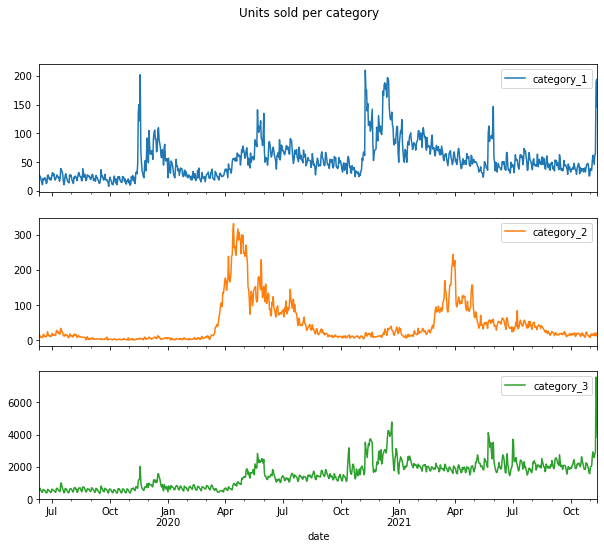

In [67]:
# Plot the series
fig, ax = plt.subplots(figsize = (10,8))
df.iloc[:, :3].plot(
    legend = True,
    subplots = True,
    sharex = True, 
    title = "Units sold per category",
    ax = ax
);

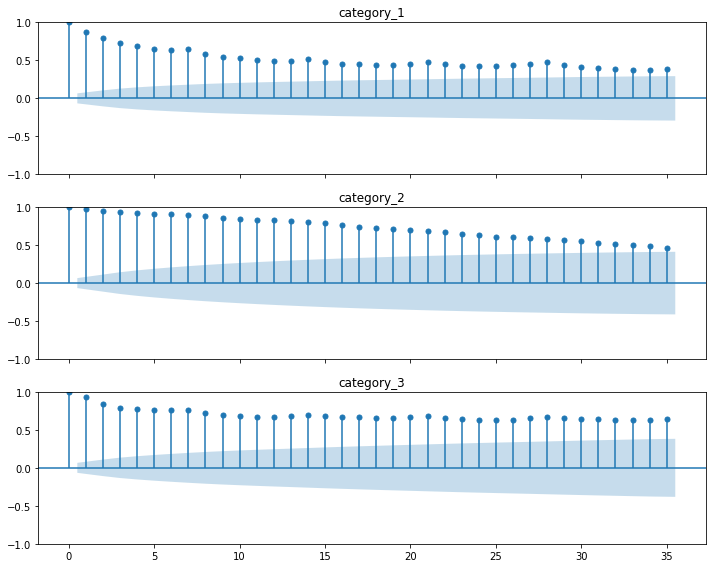

In [68]:
# Autocorrelation plots
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8), sharex = True)
axes = axes.flat
for i, col in enumerate(df.columns[:3]):
    plot_acf(df[col], ax = axes[i], lags = 7*5)
    axes[i].set_title(f"{col}")
fig.tight_layout()
plt.show()    

Observamos que existe una asociación positiva entre las ventas de un día versus los de la semana anterior. Así que los modelos autorregresivos son una buena opción.

### Individual forecasting by category

In [90]:
# Train a different model for each category and estimate Mean Absolute Error using backtesting
categories = []
mae_values = []
predictions = {}

# Loop to create each model
for i, category in enumerate(tqdm(df.columns)):
    # Define forecaster
    forecaster = ForecasterAutoreg(
                    regressor = HistGradientBoostingRegressor(random_state=123),
                    lags = 14,
                    transformer_y= StandardScaler()
    )
    # Backtesting forecaster
    metric, preds = backtesting_forecaster(
        forecaster=forecaster,
        y = df[category],
        initial_train_size = len(df_train) + len(df_test),
        steps = 21,
        metric = "mean_absolute_error",
        refit = False,
        fixed_train_size = False,
        verbose = False
    )
    categories.append(category)
    mae_values.append(metric)
    predictions[category] = preds

# Results
uni_series_mae = pd.Series(
    data = mae_values,
    index = categories,
    name = 'uni_series_mae'
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.23it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.05it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


### Multiserie Forecasting

In [76]:
# Train a model for all the categories
categories = list(df.columns)

# Define forecaster
forecaster_multi = ForecasterAutoregMultiSeries(
    regressor=HistGradientBoostingRegressor(random_state=123),
    lags=14,
    transformer_series=StandardScaler()
)
# Backtesting forecaster
multi_series_mae, preds_multi = backtesting_forecaster_multiseries(
    forecaster=forecaster_multi,
    series=df,
    levels=categories,
    steps=21,
    metric='mean_absolute_error',
    initial_train_size=len(df_train)+len(df_test),
    refit = False,
    fixed_train_size=False,
    verbose=False
)
# Results
display(multi_series_mae)
print('-------------')
display(preds_multi.head())

  0%|          | 0/5 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,category_1,10.630443
1,category_2,5.449253
2,category_3,339.835487


-------------


,category_1,category_2,category_3
2021-07-31,43.374889,43.072192,1648.241670
2021-08-01,46.293453,42.998269,1896.551218
2021-08-02,64.961399,48.121701,1953.243719
2021-08-03,69.274717,49.044735,2013.779703
2021-08-04,61.315824,49.910971,1961.269419


In [77]:
# Compare two models
multi_series_mae = multi_series_mae.set_index('levels')
multi_series_mae.columns = ['multi_series_mae']
results = pd.concat(
    [uni_series_mae, multi_series_mae], axis = 1
)
results['improvement'] = results.eval('uni_series_mae - multi_series_mae')
results['improvement %'] = 100 * results.eval('(uni_series_mae - multi_series_mae) / uni_series_mae')
results = results.round(2)
results

,uni_series_mae,multi_series_mae,improvement,improvement %
category_1,10.80,10.63,0.17,1.59
category_2,6.37,5.45,0.92,14.47
category_3,368.99,339.84,29.15,7.90


In [80]:
# Mean improvements
results[['improvement', 'improvement %']].agg(['mean', 'min', 'max']).round(2)

,improvement,improvement %
mean,10.08,7.99
min,0.17,1.59
max,29.15,14.47


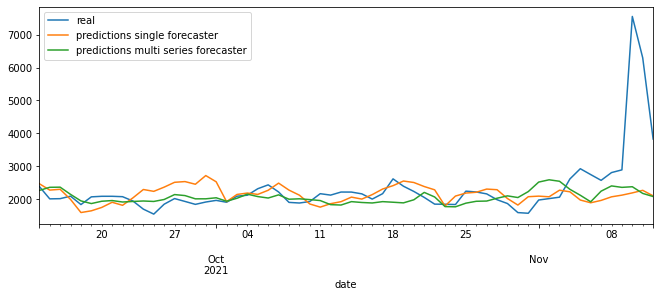

In [92]:
# Plot the item with the best improvement
fig, ax=plt.subplots(figsize=(11, 4))
df_val['category_3'].tail(60).plot(ax=ax)
predictions['category_3'].tail(60).plot(ax=ax)
preds_multi['category_3'].tail(60).plot(ax=ax)
ax.legend(['real', 'predictions single forecaster', 'predictions multi series forecaster']);

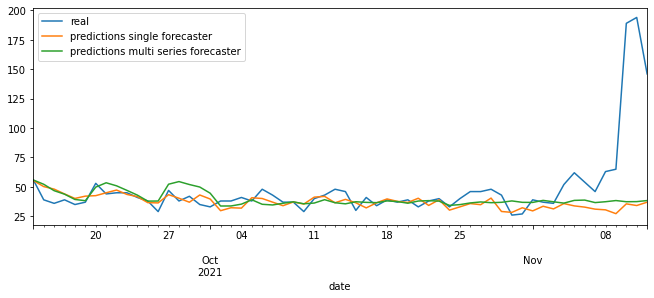

In [93]:
# Plot the item with the lowest improvement
fig, ax=plt.subplots(figsize=(11, 4))
df_val['category_1'].tail(60).plot(ax=ax)
predictions['category_1'].tail(60).plot(ax=ax)
preds_multi['category_1'].tail(60).plot(ax=ax)
ax.legend(['real', 'predictions single forecaster', 'predictions multi series forecaster']);

### Hiperparameter tuning

In [94]:
# Hide progress bar
from tqdm import tqdm 
from functools import partialmethod 
tqdm.__init__ = partialmethod(tqdm.__init__, disable = True)

In [97]:
# Hiperparameter tuning single model per category 
categories = [] 
mae_values = [] 
lags_grid = [7,14,21]
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 5, 10, None],
    'learning_rate': [0.01, 0.1]
}

# For loop 
for i, category in enumerate(df.columns):

    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=123),
                     lags          = 14,
                     transformer_y = StandardScaler()
                 )

    results_grid = grid_search_forecaster(
                       forecaster         = forecaster,
                       y                  = df.loc[:end_test, category],
                       lags_grid          = lags_grid,
                       param_grid         = param_grid,
                       steps              = 7,
                       metric             = 'mean_absolute_error',
                       initial_train_size = len(df_train),
                       refit              = False,
                       fixed_train_size   = False,
                       return_best        = True,
                       verbose            = False
                   )

    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = df[category],
                        initial_train_size = len(df_train) + len(df_test),
                        steps              = 21,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False
                    )

    categories.append(category)
    mae_values.append(metric)

uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = categories,
                     name  = 'uni_series_mae'
                 )

Number of models compared: 48.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 500}
  Backtesting metric: 11.556725492290091



  0%|          | 0/5 [00:00<?, ?it/s]

Number of models compared: 48.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 100}
  Backtesting metric: 16.23772149212425



  0%|          | 0/5 [00:00<?, ?it/s]

Number of models compared: 48.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 500}
  Backtesting metric: 322.3502697322319



  0%|          | 0/5 [00:00<?, ?it/s]

In [99]:
# Hiperparameter tuning multiserie model
lags_grid = [7, 14, 21]
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 5, 10, None],
    'learning_rate': [0.01, 0.1]
}

forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=123),
                    lags               = 14,
                    transformer_series = StandardScaler(),
                )

results_grid_ms = grid_search_forecaster_multiseries(
                      forecaster         = forecaster_ms,
                      series             = df.loc[:end_test, :],
                      levels             = None, # Si es None se seleccionan todos los niveles
                      lags_grid          = lags_grid,
                      param_grid         = param_grid,
                      steps              = 7,
                      metric             = 'mean_absolute_error',
                      initial_train_size = len(df_train),
                      refit              = False,
                      fixed_train_size   = False,
                      return_best        = True,
                      verbose            = False
                  )      

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = df,
                                       levels             = None, # Si es None se seleccionan todos los niveles
                                       steps              = 7,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(df_train) + len(df_test),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False)

48 models compared for 3 level(s). Number of iterations: 48.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500}
  Backtesting metric: 112.90765012294194
  Levels: ['category_1', 'category_2', 'category_3']



  0%|          | 0/15 [00:00<?, ?it/s]

In [102]:
# Comparison between multiseries and single series model
multi_series_mae = multi_series_mae.set_index('levels')
multi_series_mae.columns = ['multi_series_mae']
results = pd.concat((uni_series_mae, multi_series_mae), axis = 1)
results['improvement'] = results.eval('uni_series_mae - multi_series_mae')
results['improvement %'] = 100 * results.eval('(uni_series_mae - multi_series_mae) / uni_series_mae')
results = results.round(2)
results

,uni_series_mae,multi_series_mae,improvement,improvement %
category_1,11.04,8.65,2.39,21.66
category_2,22.78,3.92,18.86,82.78
category_3,354.93,263.78,91.14,25.68


In [103]:
# Mean results
results[['improvement', 'improvement %']].agg(['mean', 'min', 'max'])

,improvement,improvement %
mean,37.463333,43.373333
min,2.390000,21.660000
max,91.140000,82.780000


We observe that the multiseries model after hyperparameter tuning still performs better. This is caused by having time series with similar dynamics. An advantage of using this model is that only one model should be maintained versus three or n models.

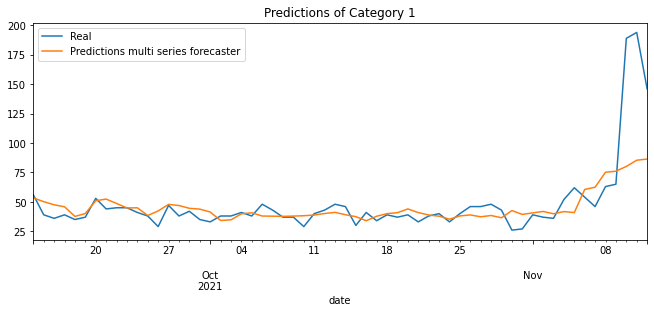

In [111]:
# Predictions Category 1
fig, ax=plt.subplots(figsize=(11, 4))
df_val['category_1'].tail(60).plot(ax=ax)
predictions_ms['category_1'].tail(60).plot(ax=ax)
ax.legend(['Real', 'Predictions multi series forecaster'])
plt.title("Predictions of Category 1");

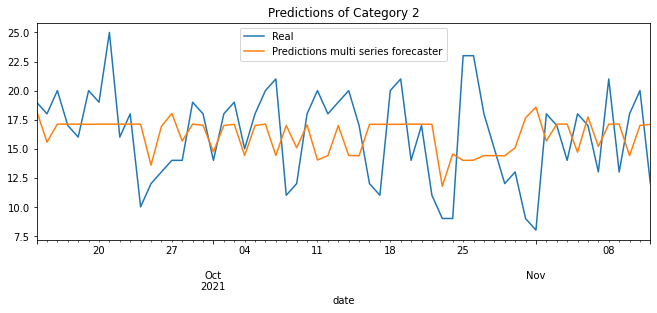

In [112]:
# Predictions Category 2
fig, ax=plt.subplots(figsize=(11, 4))
df_val['category_2'].tail(60).plot(ax=ax)
predictions_ms['category_2'].tail(60).plot(ax=ax)
ax.legend(['Real', 'Predictions multi series forecaster'])
plt.title("Predictions of Category 2");

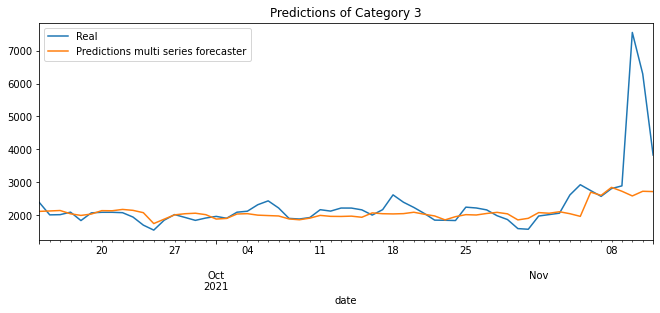

In [113]:
# Predictions Category 2
fig, ax=plt.subplots(figsize=(11, 4))
df_val['category_3'].tail(60).plot(ax=ax)
predictions_ms['category_3'].tail(60).plot(ax=ax)
ax.legend(['Real', 'Predictions multi series forecaster'])
plt.title("Predictions of Category 3");